# HD molecule in 1D

This notebook demonstrates basic use of the split-step Fourier routines on a 3D example, that of a 1D HD molecule without the Born--Oppenheimer approximation. An external laser field perturbs the system. The nuclear potential is a gaussian well or a smoothed Coulomb potential.

The HD molecule is a 4 particle problem: one H nucleus, one D nucleus, and 2 electrons.

In [15]:
import numpy as np
from fft_tdse import *
from psiviz import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

In [6]:
q = [1.0, 1.0, -1.0, -1.0] # charges of particles
m = [200, 100, 1, 1]  #masses of particles
mu = [m[0]*m[1]/(m[0]+m[1]), m[0]*m[2]/(m[0]+m[2]), m[0]*m[3]/(m[0]+m[3])] # reduced masses

# model Coulomb potential
Ufun = lambda x: np.exp(-0.1*x**2)
# manybody potentials
Vfun = lambda xx: q[0]*q[1]*Ufun(xx[0]) + q[0]*q[2]*Ufun(xx[1]) + q[0]*q[3]*Ufun(xx[2]) + q[1]*q[2]*Ufun(xx[0]-xx[1]) + q[1]*q[3]*Ufun(xx[0]-xx[2]) + q[2]*q[3]*Ufun(xx[1]-xx[2])
Tfun = lambda kk: (1.0/m[0]) * (kk[0]*kk[1] + kk[0]*kk[2] + kk[1]*kk[2]) + (0.5/mu[0])*kk[0]**2 + (0.5/mu[1])*kk[1]**2 + (0.5/mu[2])*kk[2]**2
Dfun = lambda xx: q[1]*xx[0] + q[2]*xx[1] * q[3]*xx[2]


Iteration 0, delta = 0.33909570621136936, resid = 0.15700327902602865, E = -1.557202932476251
Iteration 1, delta = 0.1438662305021051, resid = 0.05984947344863455, E = -1.5872280600185986
Iteration 2, delta = 0.07395722965674904, resid = 0.030128687909673334, E = -1.593456176505974
Iteration 3, delta = 0.057161597546821166, resid = 0.023101939459164292, E = -1.5963439761758331
Iteration 4, delta = 0.05556543317601168, resid = 0.022316874918214095, E = -1.5988328276833095
Iteration 5, delta = 0.05702632115836662, resid = 0.022758646272718563, E = -1.6013966493855283
Iteration 6, delta = 0.058975137674887254, resid = 0.023377788684380365, E = -1.6041164550877296
Iteration 7, delta = 0.060861297911920645, resid = 0.023951934800693842, E = -1.6069973421172055
Iteration 8, delta = 0.06248484972696704, resid = 0.02440359554161131, E = -1.6100198531192425
Iteration 9, delta = 0.06371182828046822, resid = 0.024684583652575198, E = -1.6131488677597614
Iteration 10, delta = 0.06443516922658665, 

Iteration 84, delta = 0.0004960033385382914, resid = 0.0001737236638199124, E = -1.649753067576223
Iteration 85, delta = 0.0004640585895485115, resid = 0.00016253503816448535, E = -1.6497532236198094
Iteration 86, delta = 0.00043417431724253986, resid = 0.0001520681064442995, E = -1.6497533602122918
Iteration 87, delta = 0.00040621715545759407, resid = 0.00014227615395508337, E = -1.6497534797798787
Iteration 88, delta = 0.000380062439218453, resid = 0.00013311551423199838, E = -1.6497535844458298
Iteration 89, delta = 0.0003555936268267401, resid = 0.00012454536651371572, E = -1.6497536760683351
Iteration 90, delta = 0.00033270176183243234, resid = 0.00011652754719867273, E = -1.6497537562736688
Iteration 91, delta = 0.00031128497192518123, resid = 0.00010902637425007304, E = -1.6497538264851803
Iteration 92, delta = 0.00029124800201984477, resid = 0.00010200848359420535, E = -1.6497538879486309
Iteration 93, delta = 0.0002725017790513814, resid = 9.544267663462566e-05, E = -1.6497539

Iteration 165, delta = 2.2698923919090583e-06, resid = 7.950200651215608e-07, E = -1.6497543198890376
Iteration 166, delta = 2.1238671237980384e-06, resid = 7.438753578117755e-07, E = -1.6497543198923057
Iteration 167, delta = 1.987235913161714e-06, resid = 6.960208568938462e-07, E = -1.6497543198951687
Iteration 168, delta = 1.859394333001014e-06, resid = 6.512449081851067e-07, E = -1.6497543198976727
Iteration 169, delta = 1.7397769942772786e-06, resid = 6.093494482870841e-07, E = -1.649754319899867
Iteration 170, delta = 1.627854791929609e-06, resid = 5.701492093761594e-07, E = -1.649754319901788
Iteration 171, delta = 1.523132728565972e-06, resid = 5.334707254884194e-07, E = -1.6497543199034646
Iteration 172, delta = 1.4251475358654691e-06, resid = 4.991518718577709e-07, E = -1.649754319904939
Iteration 173, delta = 1.3334659043984987e-06, resid = 4.6704077742579467e-07, E = -1.6497543199062272
Iteration 174, delta = 1.247682242046323e-06, resid = 4.3699538813776393e-07, E = -1.649

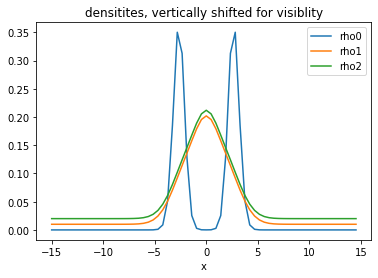

In [19]:
L = 50
ng = 256
grid = FourierGrid([-L,-L,-L], [L,L,L], [ng, ng, ng])

def compute_ground_state(L2,ng2,Tfun,Vfun):
    """ Compute ground state wavefunction on a suitable grid, 
    and then extrapolate to the computationa grid. """
    
    grid2 = FourierGrid([-L2,-L2,-L2],[L2,L2,L2],[ng2,ng2,ng2])
    xx = grid2.xx
    
    ham = FourierHamiltonian(grid2, Tfun = Tfun, Vfun = Vfun)
        
    gs = GroundStateComputer(ham)
    gs.setInitialGuess(np.exp(-(xx[0]**2 + xx[1]**2 + xx[2]**2)/2))
    
    E = gs.invit(sigma = np.min(ham.V), tol=1e-7)

    plt.figure()
    plt.plot(grid2.x[0],gs.wf.density(0))
    plt.plot(grid2.x[1],gs.wf.density(1)+.01)
    plt.plot(grid2.x[2],gs.wf.density(2)+.02)
    plt.legend(['rho0', 'rho1', 'rho2'])
    plt.xlabel('x')
    plt.title('densitites, vertically shifted for visiblity')
    plt.show()
    
    
    return gs.wf.interpolate(grid).psi

# Compute ground state on a smaller grid, then extrapolate.
psi0 = compute_ground_state(15,64,Tfun,Vfun)

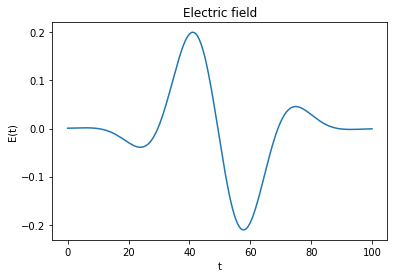

In [20]:
# Set up laser field
E0, tau, om, T = 0.25, 20.5, 1.0/(2*np.pi), 50
t_final = 100

Efun = lambda t: E0*np.exp(-(t-T)**2/tau**2) * np.cos(om*t)

plt.figure()
t = np.linspace(0,t_final,200)
plt.plot(t,Efun(t))
plt.title('Electric field')
plt.xlabel('t')
plt.ylabel('E(t)')
plt.show()


In [21]:
def visualize(wf,heading):
    """ Visualize the wavefunction. """
    plt.figure()
    plt.plot(grid.x[0],wf.density(0))
    plt.plot(grid.x[1],wf.density(1)+.01)
    plt.plot(grid.x[2],wf.density(2)+.02)
    plt.legend(['rho0', 'rho1', 'rho2'])
    plt.xlabel('x')
    plt.title(heading)
    plt.show()
    

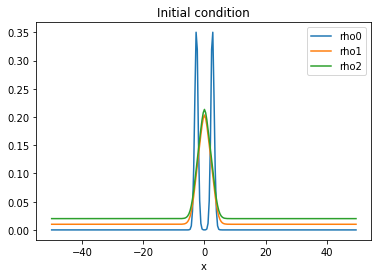

In [22]:
# Set up initial condition.

# Create a wavefunction object
wf = FourierWavefunction(grid)
wf.setPsi(psi0,normalize=True)
visualize(wf,'Initial condition')

# Set up Hamiltonian
ham = FourierHamiltonian(grid, Tfun=Tfun, Vfun = Vfun, Dfun = Dfun, Efun=Efun)

# Create a Strang splitting propagator
dt = 0.01 
prop = Propagator(ham, dt)

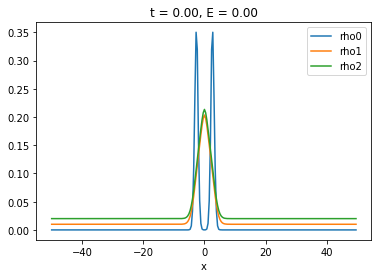

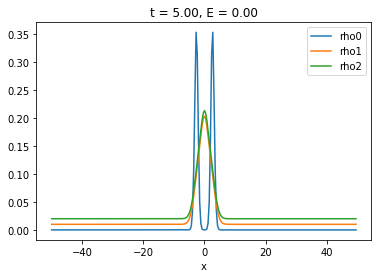

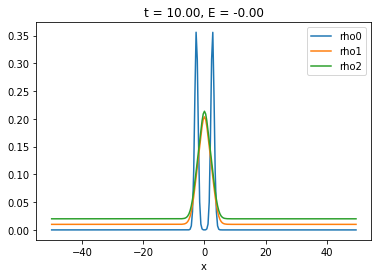

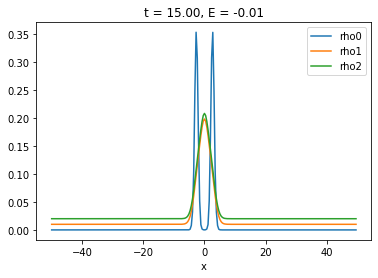

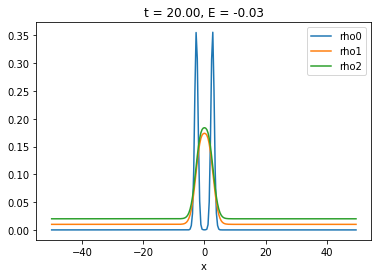

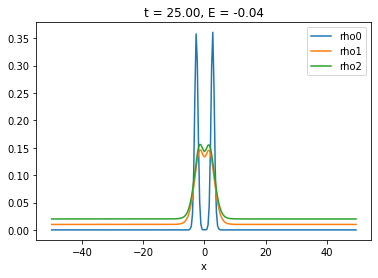

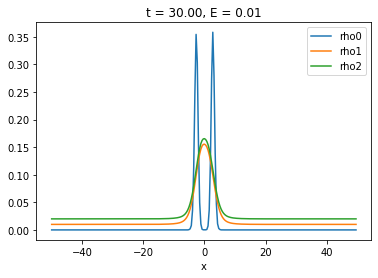

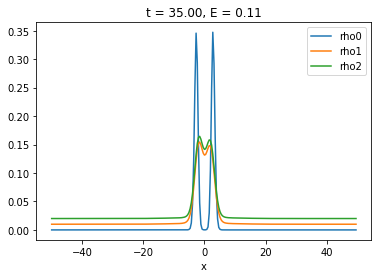

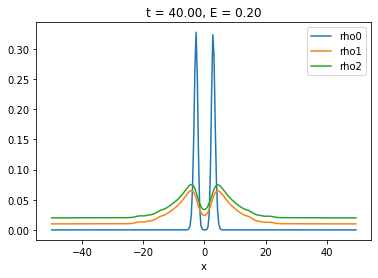

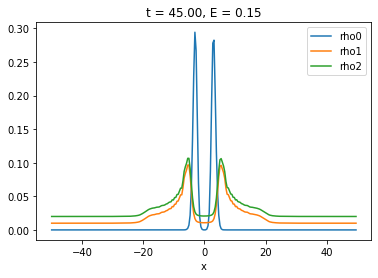

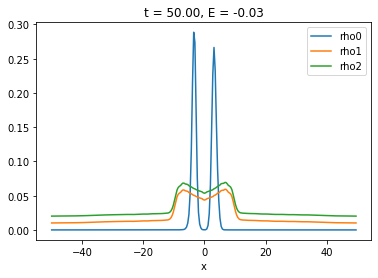

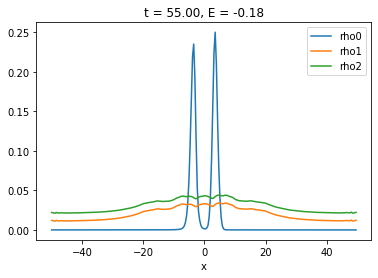

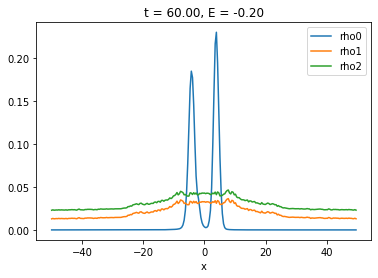

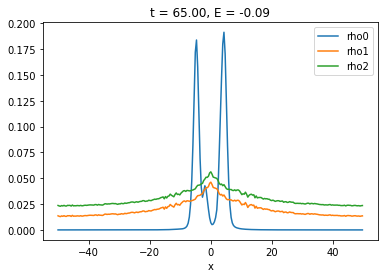

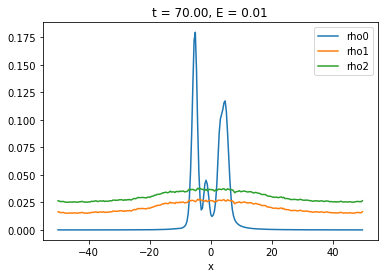

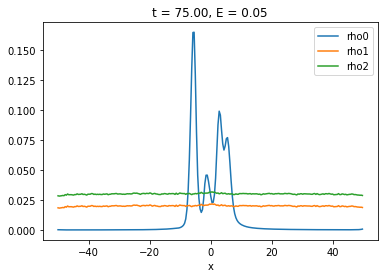

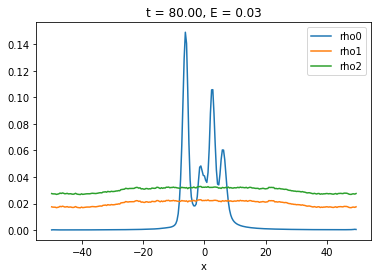

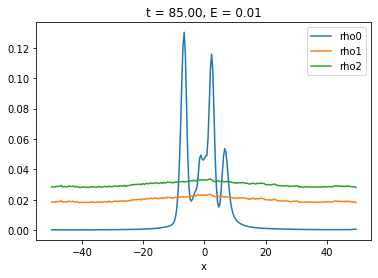

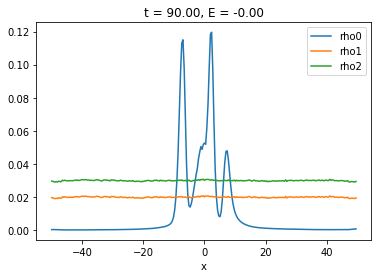

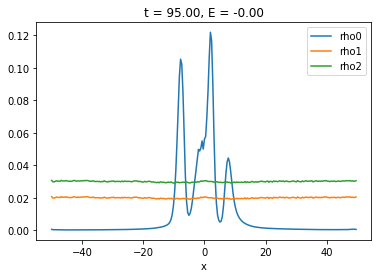

In [23]:
t_range = np.arange(0,t_final,dt)
dens_hist = np.zeros((len(grid.x[0]),len(t_range), 3), dtype=float)
curr_hist = np.zeros((len(grid.x[0]),len(t_range), 3), dtype=float)
for i in tqdm(range(len(t_range))):
    t = t_range[i]
    for n in range(3):
        dens_hist[:,i,n] = wf.density(n)
    if i % int(t_final/20/dt) == 0:
        visualize(wf,f't = {t:.2f}, E = {Efun(t):.2f}')
    prop.strang(wf,t)


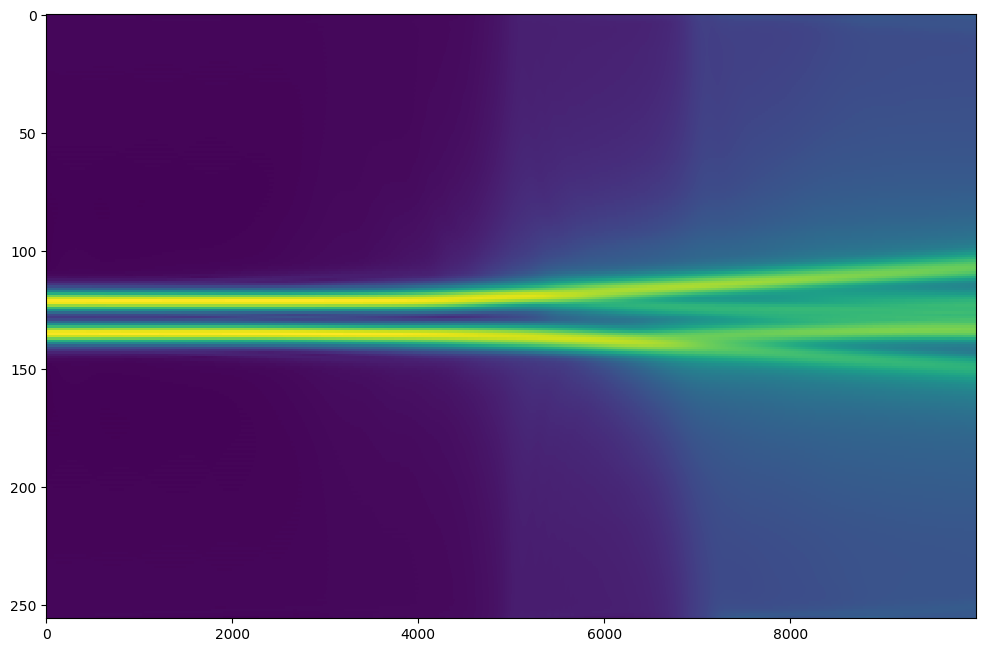

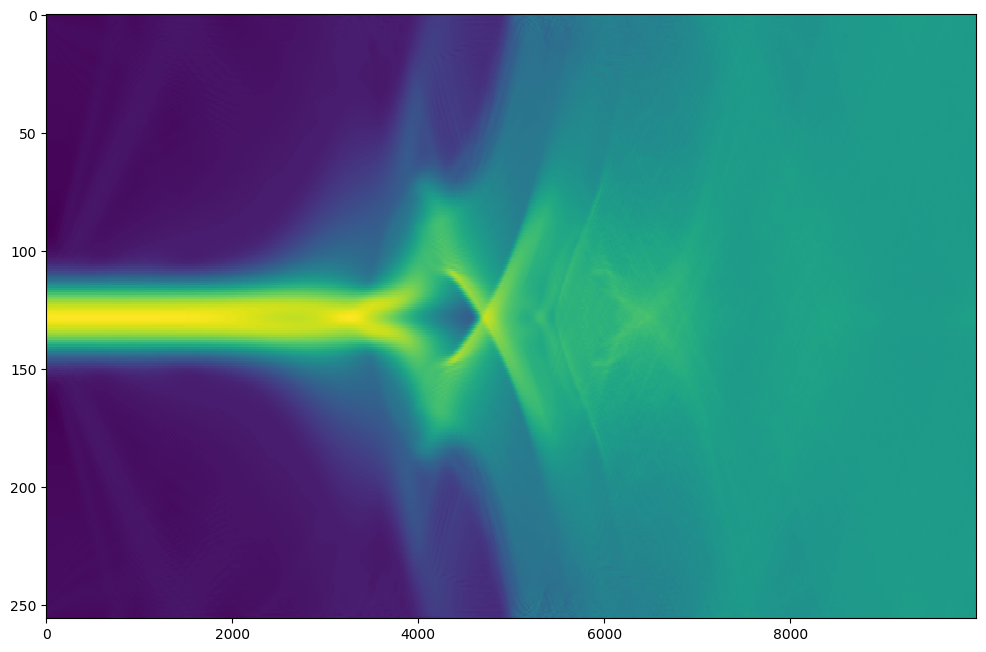

In [33]:
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(dens_hist[:,:,0]**.2,aspect='auto')
plt.figure(figsize=(12,8), dpi= 100)
plt.imshow(dens_hist[:,:,1]**.2,aspect='auto')
#plt.figure(figsize=(12,8), dpi= 100)
#plt.imshow(dens_hist[:,:,2]-dens_hist[:,:,1],aspect='auto')
#plt.colorbar()
plt.show()